In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy import signal
import librosa

In [2]:
# Download data to your colab instance
#!wget https://raw.githubusercontent.com/ursinus-cs372-s2023/Week13_NSynthClassify/main/data/nsynth_valid.mp3
#!wget https://raw.githubusercontent.com/ursinus-cs372-s2023/Week13_NSynthClassify/main/data/nsynth_test.mp3
#!wget https://raw.githubusercontent.com/ursinus-cs372-s2023/Week13_NSynthClassify/main/labels_valid.txt
#!wget https://raw.githubusercontent.com/ursinus-cs372-s2023/Week13_NSynthClassify/main/labels_test.txt    

## Data Loader

In [3]:
LABELS = ['bass_electronic', 'bass_synthetic', 'brass_acoustic', 
          'flute_acoustic', 'flute_synthetic', 'guitar_acoustic', 
          'guitar_electronic', 'keyboard_acoustic', 
          'keyboard_electronic', 'keyboard_synthetic', 
          'mallet_acoustic', 'organ_electronic', 'reed_acoustic', 
          'string_acoustic', 'vocal_acoustic', 'vocal_synthetic']

LABEL2IDX = {s:i for i, s in enumerate(LABELS)}

class Synth(Dataset):
    def __init__(self, audio_filename, labels_filename, instrument, sr, sample_len=4, clip_len=2048, augment_fac=100):
        """
        Parameters
        ----------
        audio_filename: string
            Path to audio file
        labels_filename: string
            Path to labels file
        instrument: string
            Which instrument to include
        cqt: CQT
            CQT object
        sample_len: int
            Length of each sample, in seconds
        clip_len: int
            Length of random clip to take in each data access, in samples
        """
        x, self.sr = librosa.load(audio_filename, sr=sr)
        self.x = 0.8*x/np.max(np.abs(x))
        self.labels = np.loadtxt(labels_filename)
        print("Finished loading audio ", audio_filename)
        self.sample_len = sample_len
        self.clip_len = clip_len
        label = LABEL2IDX[instrument]
        self.idxsub = np.arange(len(self.labels))[self.labels == label]
        self.augment_fac = augment_fac
    
    def __len__(self):
        return len(self.idxsub)*self.augment_fac
    
    def __getitem__(self, idx):
        """
        Return a tuple (x, y)
        """
        idx = self.idxsub[idx%len(self.idxsub)]
        L = self.sr*self.sample_len
        x = self.x[L*idx:L*idx+L]
        i1 = np.random.randint(L-self.clip_len)
        x = x[i1:i1+clip_len]
        denom = np.max(np.abs(x))
        if denom > 0:
            x = 0.6*x/denom
        x = torch.from_numpy(np.array(x, dtype=np.float32))
        y = torch.from_numpy(np.array(self.labels[idx], dtype=np.float32))
        return x.view(1, self.clip_len)
    
    


In [4]:
class Sinusoid(Dataset):
    def __init__(self, sr, N, n_samples, f=440):
        """
        Parameters
        ----------
        sr: int
            Audio sample rate
        N: int
            Number of samples per clip
        n_samples: int
            Number of samples in dataset
        f: float
            Frequency of sinusoids
        """
        self.sr = sr
        self.N = N
        self.n_samples = n_samples
        self.f = f
        self.t = np.arange(N)/sr
        
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """
        Return a tuple (x, y)
        """
        phi = np.random.rand()*2*np.pi
        y = 0.8*np.cos(2*np.pi*self.f*self.t+phi)
        y = torch.from_numpy(np.array(y, dtype=np.float32))
        return y.view(1, self.N)
    
    

In [5]:
sr = 8000
sample_len = 4
clip_len = 512

In [9]:
class AutoencoderCNN(nn.Module):
    def __init__(self, X, device, depth=4, dim_latent=2):
        """
        X: an example batch
        device: device
        """
        super(AutoencoderCNN, self).__init__()
        
        ## Step 1: Create the convolutional down layers
        last_channels = 1
        channels = 32
        down = []
        for i in range(depth):
            conv = nn.Conv1d(last_channels, channels, 3, stride=2, padding=1, bias=False)
            conv = conv.to(device)
            last_channels = channels
            channels *= 2
            down.append(conv)
            down.append(nn.LeakyReLU().to(device))
        y = X
        for layer in down:
            y = layer(y)
        shape = y.shape[1::]
        down.append(nn.Flatten())
        y = down[-1](y)
        dim = y.shape[-1]
        self.down = nn.Sequential(*down)
        
        ## Step 2: 
        self.latentdown = nn.Sequential(nn.Linear(dim, dim_latent), nn.LeakyReLU()).to(device)
        self.latentup = nn.Sequential(nn.Linear(dim_latent, dim), nn.LeakyReLU()).to(device)
        
        up = [nn.Unflatten(1, shape)]
        channels = last_channels//2
        for i in range(depth):
            upsample = nn.Upsample(scale_factor=2, mode='linear').to(device)
            convup = nn.Conv1d(last_channels, channels, 3, stride=1, padding=1, bias=False)
            convup = convup.to(device)
            up.append(upsample)
            up.append(convup)
            if i < depth-1:
                up.append(nn.LeakyReLU().to(device))
            else:
                up.append(nn.Tanh().to(device))
            last_channels = channels
            if i == depth-2:
                channels = 1
            else:
                channels = channels // 2
        self.up = nn.Sequential(*up)
    
    def forward(self, x, verbose=False):
        y = x
        if verbose:
            print(y.shape)
        for layer in self.down + self.latentdown + self.latentup + self.up:
            y = layer(y)
            if verbose:
                print(y.shape)
        return y
    
    def encode(self, x):
        return self.latentdown(self.down(x))
    
    def decode(self, x):
        return self.up(self.latentup(x))
    

data = Sinusoid(sr, clip_len, 1000)

loader = DataLoader(data, batch_size=16, shuffle=True)
X = next(iter(loader))
print(X.shape)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

model = AutoencoderCNN(X.to(device), device, depth=6)
model.forward(X.to(device), True).shape

torch.Size([16, 1, 512])
torch.Size([16, 1, 512])
torch.Size([16, 32, 256])
torch.Size([16, 32, 256])
torch.Size([16, 64, 128])
torch.Size([16, 64, 128])
torch.Size([16, 128, 64])
torch.Size([16, 128, 64])
torch.Size([16, 256, 32])
torch.Size([16, 256, 32])
torch.Size([16, 512, 16])
torch.Size([16, 512, 16])
torch.Size([16, 1024, 8])
torch.Size([16, 1024, 8])
torch.Size([16, 8192])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 1024, 8])
torch.Size([16, 1024, 16])
torch.Size([16, 512, 16])
torch.Size([16, 512, 16])
torch.Size([16, 512, 32])
torch.Size([16, 256, 32])
torch.Size([16, 256, 32])
torch.Size([16, 256, 64])
torch.Size([16, 128, 64])
torch.Size([16, 128, 64])
torch.Size([16, 128, 128])
torch.Size([16, 64, 128])
torch.Size([16, 64, 128])
torch.Size([16, 64, 256])
torch.Size([16, 32, 256])
torch.Size([16, 32, 256])
torch.Size([16, 32, 512])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])


torch.Size([16, 1, 512])

Device:  cuda
Finished loading audio  nsynth_valid.mp3
Epoch 0, loss 1802559.142
Epoch 1, loss 1761066.006
Epoch 2, loss 1748971.388
Epoch 3, loss 1737080.440
Epoch 4, loss 1724704.197
Epoch 5, loss 1721483.106
Epoch 6, loss 1727964.208
Epoch 7, loss 1718519.098
Epoch 8, loss 1713294.481
Epoch 9, loss 1711724.443
Epoch 10, loss 1715888.487
Epoch 11, loss 1696579.457
Epoch 12, loss 1700225.350
Epoch 13, loss 1706815.691
Epoch 14, loss 1700558.886
Epoch 15, loss 1703050.605
Epoch 16, loss 1689504.360
Epoch 17, loss 1692565.690
Epoch 18, loss 1691370.216
Epoch 19, loss 1698924.304
Epoch 20, loss 1694478.221
Epoch 21, loss 1694589.267
Epoch 22, loss 1687718.976
Epoch 23, loss 1681774.445
Epoch 24, loss 1682709.659
Epoch 25, loss 1691055.446
Epoch 26, loss 1686965.044
Epoch 27, loss 1680772.979
Epoch 28, loss 1691597.278
Epoch 29, loss 1687105.360
Epoch 30, loss 1686936.531
Epoch 31, loss 1681171.293
Epoch 32, loss 1675920.480
Epoch 33, loss 1675503.235
Epoch 34, loss 1678715.386
Epoch 35, 

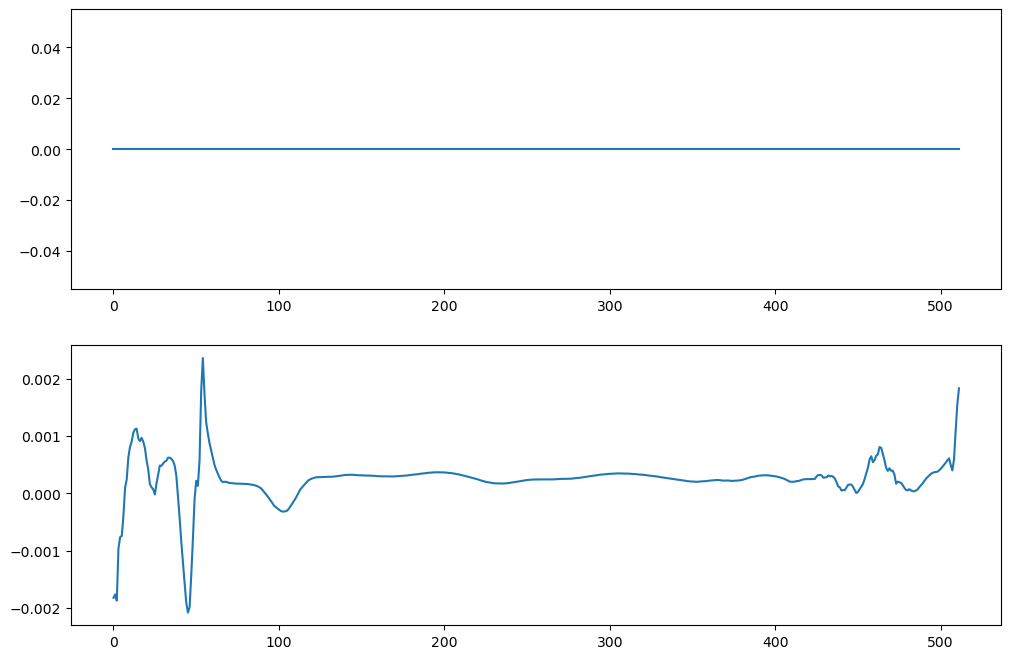

In [14]:
# Try to use the GPU

print("Device: ", device)

## Step 2: Create model with a test batch
#data = Sinusoid(sr, clip_len, 10000)
data = Synth("nsynth_valid.mp3", "labels_valid.txt", "keyboard_electronic", sr, sample_len, clip_len, augment_fac=10)
loader = DataLoader(data, batch_size=64, shuffle=True)
X = next(iter(loader)).to(device)

model = AutoencoderCNN(X, device, depth=5, dim_latent=2)


## Step 3: Setup the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100 # Each "epoch" is a loop through the entire dataset
# and we use this to update the parameters
train_losses = []

plt.figure(figsize=(12, 8))

for epoch in range(n_epochs):
    loader = DataLoader(data, batch_size=16, shuffle=True)
    train_loss = 0
    for X in loader: # Go through each mini batch
        # Move inputs/outputs to GPU
        X = X.to(device)
        # Reset the optimizer's gradients
        optimizer.zero_grad()
        # Run the sequential model on all inputs
        X_est = model(X)
        # Compute the loss function comparing Y_est to Y
        loss = torch.sum(torch.abs(X_est - X))
        # Compute the gradients of the loss function with respect
        # to all of the parameters of the model
        loss.backward()
        # Update the parameters based on the gradient and
        # the optimization scheme
        optimizer.step()
        train_loss += loss.item()
    
    print("Epoch {}, loss {:.3f}".format(epoch, train_loss))
    train_losses.append(train_loss)
    
    plt.clf()
    plt.subplot(211)
    plt.plot(X.detach().cpu()[0, 0, :])
    plt.subplot(212)
    plt.plot(X_est.detach().cpu()[0, 0, :])
    plt.savefig("Epoch{}.png".format(epoch))